In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.nn.functional as F
import torch.utils.data as data
import pandas as pd

import torchvision
from torchvision.models import resnet18, ResNet18_Weights, vgg16, VGG16_Weights
from torchvision import datasets
from torchvision import transforms

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


import os
from torchsummary import summary



# from google.colab import drive
# drive.mount('/content/drive')
# #Code folder path
# %cd /content/drive/My Drive/ECE591_DL_CL_PROJECT/

#device config
torch.cuda.set_device(1)#Select GPU device 1
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


#Datasets
#Tiny-imagenet: http://cs231n.stanford.edu/tiny-imagenet-200.zip
#Tiny-imagenet-C: https://zenodo.org/records/2469796

#CIFAR-10:  https://www.cs.toronto.edu/~kriz/cifar.html
#CIFAR-10C: https://zenodo.org/records/2535967


In [8]:
# Returns a list of transformations when called
class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #Normalize all the images
        ]
        return test_transforms

transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams()) 

In [9]:
#Create Loaders
DataPath="./Datasets/TINY-IMAGENET/tiny-imagenet-200"
trainset = datasets.ImageFolder(DataPath+'/train', transform=train_transforms)
testset = datasets.ImageFolder(DataPath+'/test_pro', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,shuffle=False, num_workers=2)


In [10]:
#following: https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        DROPOUT = 0.1

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes),
                nn.Dropout(DROPOUT)
            )

    def forward(self, x):
        out = F.relu(self.dropout(self.bn1(self.conv1(x))))
        out = self.dropout(self.bn2(self.conv2(out)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=200):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1) #the blocks we repeat have stride 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return F.log_softmax(out, dim=-1)


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

model = ResNet18().to(device)
summary(model, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
           Dropout-5           [-1, 64, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          36,864
       BatchNorm2d-7           [-1, 64, 64, 64]             128
           Dropout-8           [-1, 64, 64, 64]               0
        BasicBlock-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
          Dropout-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
      BatchNorm2d-14           [-1, 64,

In [11]:
def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):

    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target) #negative log likelihood loss


        train_losses.append(loss.item())
        loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update).

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        # print statistics
        running_loss += loss.item()
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):

    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0


    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))

    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified


In [12]:
# Training the model
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)


train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 50

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)

    #Save every multiple of 10 epochs
    if i%10==0:
        torch.save(model.state_dict(), "./Networks/ResNet18_TINY_IMAGENET_V0.pt")
        np.savez("./Networks/TrainSteps_ResNet18_TinyImagenet_V0.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

torch.save(model.state_dict(), "./Networks/ResNet18_TINY_IMAGENET_V0.pt")
np.savez("./Networks/TrainSteps_ResNet18_TinyImagenet_V0.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)   

EPOCHS : 0


Loss=4.197043418884277 Batch_id=390 Accuracy=6.38: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 



Test set: Average loss: 4.2242, Accuracy: 487/5000 (9.74%)

EPOCHS : 1


Loss=3.841252088546753 Batch_id=390 Accuracy=15.51: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 



Test set: Average loss: 3.7039, Accuracy: 904/5000 (18.08%)

EPOCHS : 2


Loss=3.204875946044922 Batch_id=390 Accuracy=21.99: 100%|██████████| 391/391 [03:21<00:00,  1.95it/s] 



Test set: Average loss: 3.2979, Accuracy: 1244/5000 (24.88%)

EPOCHS : 3


Loss=2.890641689300537 Batch_id=390 Accuracy=27.19: 100%|██████████| 391/391 [03:23<00:00,  1.93it/s] 



Test set: Average loss: 3.0645, Accuracy: 1464/5000 (29.28%)

EPOCHS : 4


Loss=3.0569851398468018 Batch_id=390 Accuracy=31.15: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]



Test set: Average loss: 3.0042, Accuracy: 1498/5000 (29.96%)

EPOCHS : 5


Loss=2.8905673027038574 Batch_id=390 Accuracy=34.55: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]



Test set: Average loss: 3.0749, Accuracy: 1457/5000 (29.14%)

EPOCHS : 6


Loss=2.6540873050689697 Batch_id=390 Accuracy=37.45: 100%|██████████| 391/391 [03:08<00:00,  2.07it/s]



Test set: Average loss: 2.6655, Accuracy: 1856/5000 (37.12%)

EPOCHS : 7


Loss=2.579780340194702 Batch_id=390 Accuracy=39.73: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s] 



Test set: Average loss: 2.7385, Accuracy: 1789/5000 (35.78%)

EPOCHS : 8


Loss=2.422858953475952 Batch_id=390 Accuracy=41.99: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s] 



Test set: Average loss: 2.5899, Accuracy: 1945/5000 (38.90%)

EPOCHS : 9


Loss=2.560633897781372 Batch_id=390 Accuracy=44.14: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s] 



Test set: Average loss: 2.4210, Accuracy: 2081/5000 (41.62%)

EPOCHS : 10


Loss=2.2124950885772705 Batch_id=390 Accuracy=45.95: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]



Test set: Average loss: 2.3632, Accuracy: 2198/5000 (43.96%)

EPOCHS : 11


Loss=2.1551084518432617 Batch_id=390 Accuracy=47.37: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]



Test set: Average loss: 2.3677, Accuracy: 2192/5000 (43.84%)

EPOCHS : 12


Loss=1.9715750217437744 Batch_id=390 Accuracy=49.16: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]



Test set: Average loss: 2.2064, Accuracy: 2331/5000 (46.62%)

EPOCHS : 13


Loss=2.2217631340026855 Batch_id=390 Accuracy=50.42: 100%|██████████| 391/391 [03:06<00:00,  2.09it/s]



Test set: Average loss: 2.2982, Accuracy: 2244/5000 (44.88%)

EPOCHS : 14


Loss=1.8190456628799438 Batch_id=390 Accuracy=51.65: 100%|██████████| 391/391 [02:07<00:00,  3.06it/s]



Test set: Average loss: 2.1917, Accuracy: 2397/5000 (47.94%)

EPOCHS : 15


Loss=1.9710071086883545 Batch_id=390 Accuracy=52.98: 100%|██████████| 391/391 [02:05<00:00,  3.11it/s]



Test set: Average loss: 2.2226, Accuracy: 2367/5000 (47.34%)

EPOCHS : 16


Loss=1.8050693273544312 Batch_id=390 Accuracy=54.32: 100%|██████████| 391/391 [02:06<00:00,  3.09it/s]



Test set: Average loss: 2.1190, Accuracy: 2481/5000 (49.62%)

EPOCHS : 17


Loss=1.9750235080718994 Batch_id=390 Accuracy=55.49: 100%|██████████| 391/391 [02:06<00:00,  3.08it/s]



Test set: Average loss: 2.0846, Accuracy: 2549/5000 (50.98%)

EPOCHS : 18


Loss=1.5073726177215576 Batch_id=390 Accuracy=56.72: 100%|██████████| 391/391 [02:06<00:00,  3.08it/s]



Test set: Average loss: 2.1052, Accuracy: 2517/5000 (50.34%)

EPOCHS : 19


Loss=1.636815071105957 Batch_id=390 Accuracy=57.49: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s] 



Test set: Average loss: 2.2043, Accuracy: 2488/5000 (49.76%)

EPOCHS : 20


Loss=1.8829710483551025 Batch_id=390 Accuracy=58.65: 100%|██████████| 391/391 [02:04<00:00,  3.13it/s]



Test set: Average loss: 2.1797, Accuracy: 2454/5000 (49.08%)

EPOCHS : 21


Loss=1.4236431121826172 Batch_id=390 Accuracy=59.76: 100%|██████████| 391/391 [02:07<00:00,  3.06it/s]



Test set: Average loss: 2.0872, Accuracy: 2539/5000 (50.78%)

EPOCHS : 22


Loss=1.5647337436676025 Batch_id=390 Accuracy=60.86: 100%|██████████| 391/391 [03:13<00:00,  2.03it/s]



Test set: Average loss: 2.1494, Accuracy: 2558/5000 (51.16%)

EPOCHS : 23


Loss=1.438137412071228 Batch_id=390 Accuracy=61.86: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s] 



Test set: Average loss: 2.0888, Accuracy: 2599/5000 (51.98%)

EPOCHS : 24


Loss=1.4180790185928345 Batch_id=390 Accuracy=62.68: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]



Test set: Average loss: 2.0091, Accuracy: 2645/5000 (52.90%)

EPOCHS : 25


Loss=1.584549903869629 Batch_id=390 Accuracy=63.54: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 



Test set: Average loss: 2.0176, Accuracy: 2653/5000 (53.06%)

EPOCHS : 26


Loss=1.6061267852783203 Batch_id=390 Accuracy=64.34: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]



Test set: Average loss: 2.0364, Accuracy: 2659/5000 (53.18%)

EPOCHS : 27


Loss=1.1690304279327393 Batch_id=390 Accuracy=65.23: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]



Test set: Average loss: 2.0656, Accuracy: 2615/5000 (52.30%)

EPOCHS : 28


Loss=1.5015885829925537 Batch_id=390 Accuracy=66.16: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]



Test set: Average loss: 2.0121, Accuracy: 2710/5000 (54.20%)

EPOCHS : 29


Loss=1.376247763633728 Batch_id=390 Accuracy=66.82: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s] 



Test set: Average loss: 2.0398, Accuracy: 2691/5000 (53.82%)

EPOCHS : 30


Loss=1.1584365367889404 Batch_id=390 Accuracy=67.89: 100%|██████████| 391/391 [04:23<00:00,  1.48it/s]



Test set: Average loss: 1.9970, Accuracy: 2716/5000 (54.32%)

EPOCHS : 31


Loss=1.1725857257843018 Batch_id=390 Accuracy=68.82: 100%|██████████| 391/391 [04:26<00:00,  1.47it/s]



Test set: Average loss: 1.9853, Accuracy: 2743/5000 (54.86%)

EPOCHS : 32


Loss=1.1411418914794922 Batch_id=390 Accuracy=69.50: 100%|██████████| 391/391 [04:30<00:00,  1.45it/s]



Test set: Average loss: 2.0638, Accuracy: 2689/5000 (53.78%)

EPOCHS : 33


Loss=1.16580331325531 Batch_id=390 Accuracy=70.30: 100%|██████████| 391/391 [04:24<00:00,  1.48it/s]  



Test set: Average loss: 2.0577, Accuracy: 2736/5000 (54.72%)

EPOCHS : 34


Loss=1.1512329578399658 Batch_id=390 Accuracy=71.30: 100%|██████████| 391/391 [04:26<00:00,  1.47it/s]



Test set: Average loss: 2.1345, Accuracy: 2661/5000 (53.22%)

EPOCHS : 35


Loss=1.2384451627731323 Batch_id=390 Accuracy=71.98: 100%|██████████| 391/391 [04:22<00:00,  1.49it/s]

Epoch 00036: reducing learning rate of group 0 to 5.0000e-04.



Test set: Average loss: 2.0503, Accuracy: 2774/5000 (55.48%)

EPOCHS : 36


Loss=0.8854312896728516 Batch_id=390 Accuracy=78.74: 100%|██████████| 391/391 [04:27<00:00,  1.46it/s]



Test set: Average loss: 1.7778, Accuracy: 3003/5000 (60.06%)

EPOCHS : 37


Loss=0.9243261218070984 Batch_id=390 Accuracy=80.74: 100%|██████████| 391/391 [04:23<00:00,  1.49it/s]



Test set: Average loss: 1.7630, Accuracy: 2997/5000 (59.94%)

EPOCHS : 38


Loss=0.8196183443069458 Batch_id=390 Accuracy=81.69: 100%|██████████| 391/391 [04:26<00:00,  1.47it/s]



Test set: Average loss: 1.7570, Accuracy: 3008/5000 (60.16%)

EPOCHS : 39


Loss=0.7569816708564758 Batch_id=390 Accuracy=82.04: 100%|██████████| 391/391 [04:22<00:00,  1.49it/s] 



Test set: Average loss: 1.7570, Accuracy: 3012/5000 (60.24%)

EPOCHS : 40


Loss=0.7208017110824585 Batch_id=390 Accuracy=82.41: 100%|██████████| 391/391 [04:24<00:00,  1.48it/s]



Test set: Average loss: 1.7562, Accuracy: 3005/5000 (60.10%)

EPOCHS : 41


Loss=0.8234480619430542 Batch_id=390 Accuracy=82.82: 100%|██████████| 391/391 [04:24<00:00,  1.48it/s]



Test set: Average loss: 1.7570, Accuracy: 3000/5000 (60.00%)

EPOCHS : 42


Loss=0.582645058631897 Batch_id=390 Accuracy=82.92: 100%|██████████| 391/391 [04:22<00:00,  1.49it/s] 



Test set: Average loss: 1.7595, Accuracy: 3016/5000 (60.32%)

EPOCHS : 43


Loss=0.5831468105316162 Batch_id=390 Accuracy=83.09: 100%|██████████| 391/391 [04:22<00:00,  1.49it/s] 



Test set: Average loss: 1.7604, Accuracy: 3017/5000 (60.34%)

EPOCHS : 44


Loss=0.6312156915664673 Batch_id=390 Accuracy=83.15: 100%|██████████| 391/391 [04:25<00:00,  1.47it/s] 



Test set: Average loss: 1.7636, Accuracy: 3009/5000 (60.18%)

EPOCHS : 45


Loss=0.6547877192497253 Batch_id=390 Accuracy=83.38: 100%|██████████| 391/391 [04:24<00:00,  1.48it/s] 

Epoch 00046: reducing learning rate of group 0 to 2.5000e-05.



Test set: Average loss: 1.7565, Accuracy: 3021/5000 (60.42%)

EPOCHS : 46


Loss=0.732378363609314 Batch_id=390 Accuracy=83.98: 100%|██████████| 391/391 [04:25<00:00,  1.47it/s]  



Test set: Average loss: 1.7586, Accuracy: 3016/5000 (60.32%)

EPOCHS : 47


Loss=0.6433103680610657 Batch_id=390 Accuracy=83.79: 100%|██████████| 391/391 [04:22<00:00,  1.49it/s] 



Test set: Average loss: 1.7569, Accuracy: 3021/5000 (60.42%)

EPOCHS : 48


Loss=0.6048785448074341 Batch_id=390 Accuracy=83.87: 100%|██████████| 391/391 [04:23<00:00,  1.49it/s] 

Epoch 00049: reducing learning rate of group 0 to 1.2500e-06.



Test set: Average loss: 1.7577, Accuracy: 3026/5000 (60.52%)

EPOCHS : 49


Loss=0.550805389881134 Batch_id=390 Accuracy=83.98: 100%|██████████| 391/391 [03:38<00:00,  1.79it/s]  



Test set: Average loss: 1.7581, Accuracy: 3018/5000 (60.36%)



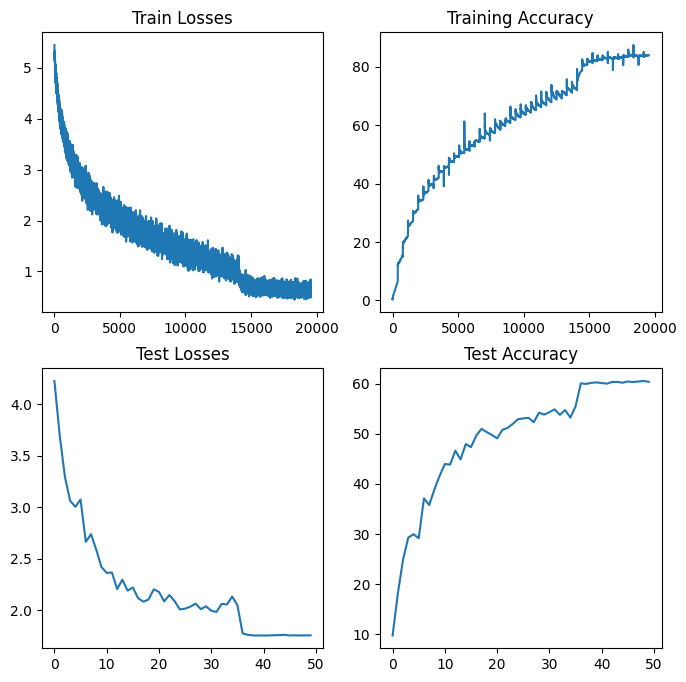

In [13]:
fig, axs = plt.subplots(2,2, figsize=(8,8))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)